In [239]:
import git
from io import StringIO
import datetime as dt
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
import locale

locale.setlocale(locale.LC_TIME, 'es_US.UTF8')
plt.style.use('../0_common/estilo.mplstyle')

In [10]:
repo = git.Repo('data/covid19-bo-casos_por_departamento/')

In [50]:
datasets = [
    'confirmados_diarios',
    'decesos_diarios',
    'recuperados_diarios',
    'activos_acumulados',
    'confirmados_acumulados',
    'decesos_acumulados',
    'recuperados_acumulados'
]

In [64]:
states = {d:[] for d in datasets}
for commit in repo.iter_commits(rev='master'):
    timestamp = dt.datetime.fromtimestamp(commit.committed_date)
    for d in datasets:
        filename = '{}.csv'.format(d)
        if filename in [e.name for e in commit.tree]:
            state = pd.read_csv(
                StringIO(
                    commit.tree[filename].data_stream.read().decode()
                ), parse_dates=[0], index_col=0).unstack().rename(timestamp)
            states[d].append(state)

In [ ]:
dfs = {}
for d in datasets:
    dfs[d] = pd.concat(states[d], axis=1)
    table = pa.Table.from_pandas(dfs[d], preserve_index=True)
    pq.write_table(table, 'data/history/{}.parquet'.format(d))

eg.:

In [386]:
dfs['decesos_acumulados']

2022-07-12 12:26:14  2022-07-11 12:28:27  \
Chuquisaca 2020-03-10                    0                  0.0   
           2020-03-11                    0                  0.0   
           2020-03-12                    0                  0.0   
           2020-03-13                    0                  0.0   
           2020-03-14                    0                  0.0   
...                                    ...                  ...   
Pando      2022-07-07                  352                352.0   
           2022-07-08                  352                352.0   
           2022-07-09                  353                353.0   
           2022-07-10                  353                353.0   
           2022-07-11                  353                  NaN   

                       2022-07-10 12:23:20  2022-07-09 18:47:49  \
Chuquisaca 2020-03-10                  0.0                  0.0   
           2020-03-11                  0.0                  0.0   
           2020-03-12                  0.0                  0.0   
           2020-03-13                  0.0                  0.0   
           2020-03-14                  0.0                  0.0   
...                                    ...                  ...   
Pando      2022-07-07                352.0                352.0   
           2022-07-08                352.0                352.0   
           2022-07-09                353.0                  NaN   
           2022-07-10                  NaN                  NaN   
           2022-07-11                  NaN                  NaN   

                       2022-07-09 18:43:40  2022-07-09 16:39:43  \
Chuquisaca 2020-03-10                  0.0                  0.0   
           2020-03-11                  0.0                  0.0   
           2020-03-12                  0.0                  0.0   
           2020-03-13                  0.0                  0.0   
           2020-03-14                  0.0                  0.0   
...                                    ...                  ...   
Pando      2022-07-07                352.0                352.0   
           2022-07-08                352.0                352.0   
           2022-07-09                  NaN                  NaN   
           2022-07-10                  NaN                  NaN   
           2022-07-11                  NaN                  NaN   

                       2022-06-30 10:14:52  2022-06-29 16:18:49  \
Chuquisaca 2020-03-10                  0.0                  0.0   
           2020-03-11                  0.0                  0.0   
           2020-03-12                  0.0                  0.0   
           2020-03-13                  0.0                  0.0   
           2020-03-14                  0.0                  0.0   
...                                    ...                  ...   
Pando      2022-07-07                  NaN                  NaN   
           2022-07-08                  NaN                  NaN   
           2022-07-09                  NaN                  NaN   
           2022-07-10                  NaN                  NaN   
           2022-07-11                  NaN                  NaN   

                       2022-06-28 12:23:22  2022-06-27 12:22:17  ...  \
Chuquisaca 2020-03-10                  0.0                  0.0  ...   
           2020-03-11                  0.0                  0.0  ...   
           2020-03-12                  0.0                  0.0  ...   
           2020-03-13                  0.0                  0.0  ...   
           2020-03-14                  0.0                  0.0  ...   
...                                    ...                  ...  ...   
Pando      2022-07-07                  NaN                  NaN  ...   
           2022-07-08                  NaN                  NaN  ...   
           2022-07-09                  NaN                  NaN  ...   
           2022-07-10                  NaN                  NaN  ...   
           

In [384]:
def plot_actualizaciones(d):
    
    dfi = dfs[d]
    title = 'Actualizaciones en el dataset de {}'.format(d.replace('_', ' '))
    filename = 'actualizaciones_{}.png'.format(d)
    
    departamentos = ['Santa Cruz', 'La Paz', 'Cochabamba', 'Beni', 'Oruro', 'Chuquisaca', 'Pando', 'Potosí', 'Tarija']
    
    f, axs = plt.subplots(3,3,figsize=(12,12), dpi=150, sharey=True, sharex=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=.03, hspace=.03)
    
    for i, (ax, dep) in enumerate(zip(axs, departamentos)):
        
        dep_df = dfi.loc[dep][dfi.columns.sort_values()]
        dep_df = dep_df.fillna(0).diff(axis=1)
        dep_df = dep_df.loc['2021-01-01':]

        edits = dates.date2num(dep_df.columns)
        case_dates = dates.date2num(dep_df.index)
    
        if 'diario' in d:
            v = 3
        else:
            v = 100
            
        norm = colors.TwoSlopeNorm(vcenter=0, vmin=0-v, vmax=v)

        im = ax.imshow(dep_df, 
                      cmap='RdBu_r', 
                      norm=norm,
                      aspect='auto', 
                      extent = [edits[0], edits[-1],  case_dates[-1], case_dates[0]])

        ax.xaxis_date()
        ax.yaxis_date()
        if i > 2:
            ax.tick_params(axis='x', labeltop=False, labelbottom=False)
        else:
            ax.tick_params(axis='x', labeltop=True, labelbottom=False, rotation=90)
        ax.grid()
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_locator(dates.MonthLocator())
            axis.set_major_formatter(dates.DateFormatter('%b'))
            
        ax.annotate(dep, 
                    xy=(.5, 0.98), 
                    xycoords='axes fraction', 
                    ha='center', 
                    va='top',
                    fontsize=6,
                    alpha=.5,
                    )
    
    axs[3].annotate('Fecha de casos', xy=(-.15, .5), xycoords='axes fraction', ha='right', va='center', fontsize=8, alpha=.5, rotation=90)
    axs[1].annotate('Fecha de actualizaciones', xy=(.5, 1.15), xycoords='axes fraction', ha='center', va='bottom', fontsize=8, alpha=.5)
    axs[7].annotate(title, xy=(.5, -.09), xycoords='axes fraction', ha='center', va='top', fontsize=10, alpha=.5, fontweight='bold', linespacing=1.5)
    axs[7].annotate('entre enero de 2021 y julio de 2022', xy=(.5, -.17), xycoords='axes fraction', ha='center', va='top', fontsize=8, alpha=.5, fontweight='bold', linespacing=1.5)
    
    axi = axs[7].inset_axes([0,-.3,1,.02])
    cbar = axs[7].figure.colorbar(im, cax=axi, orientation='horizontal')
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=5)
    cbar.set_label('Número de casos por actualización', labelpad=10)
    
    f.savefig('plots/{}'.format(filename), dpi=150, bbox_inches='tight', pad_inches=.02)

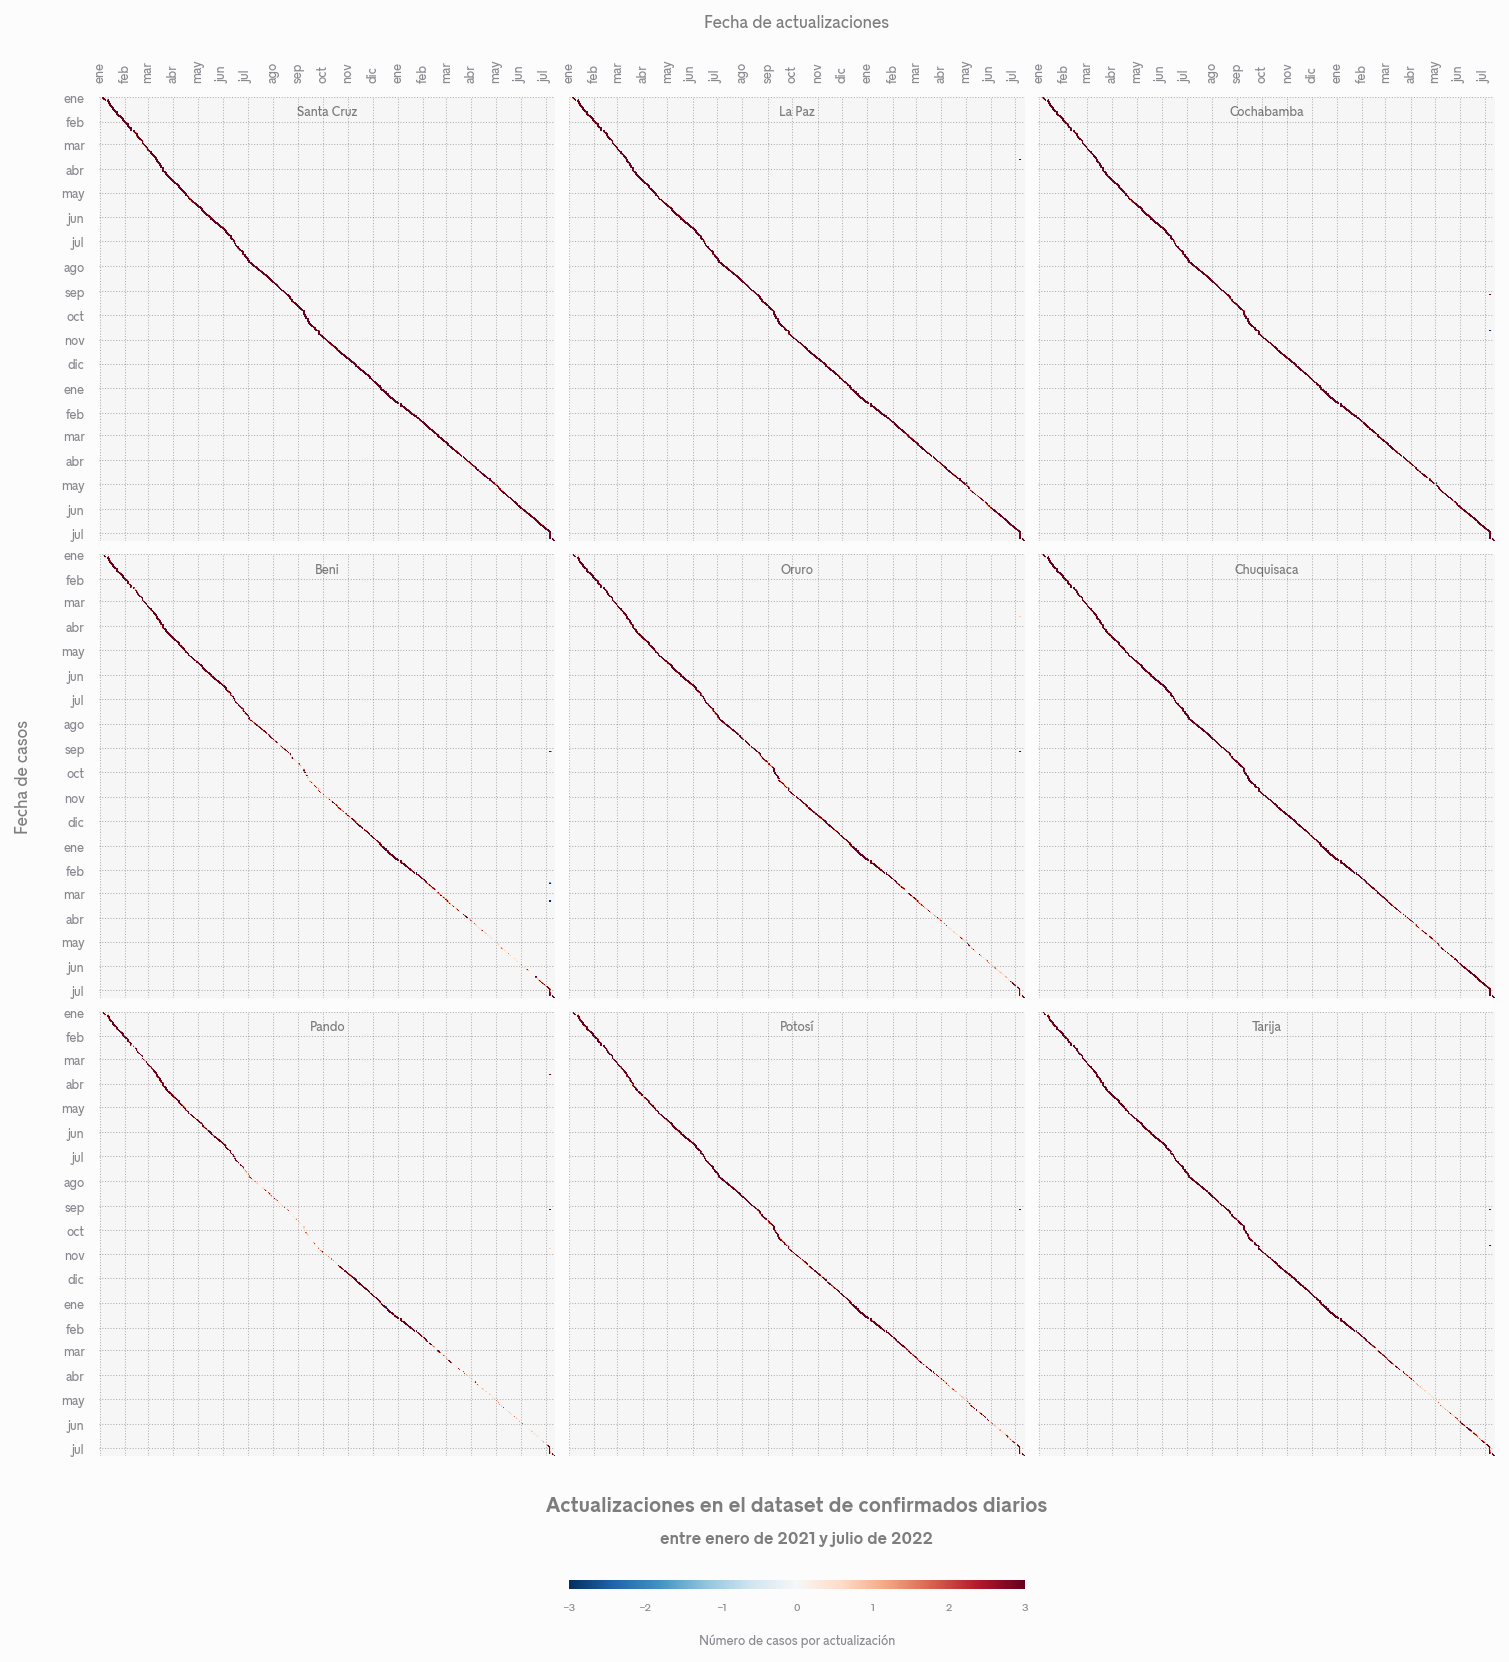

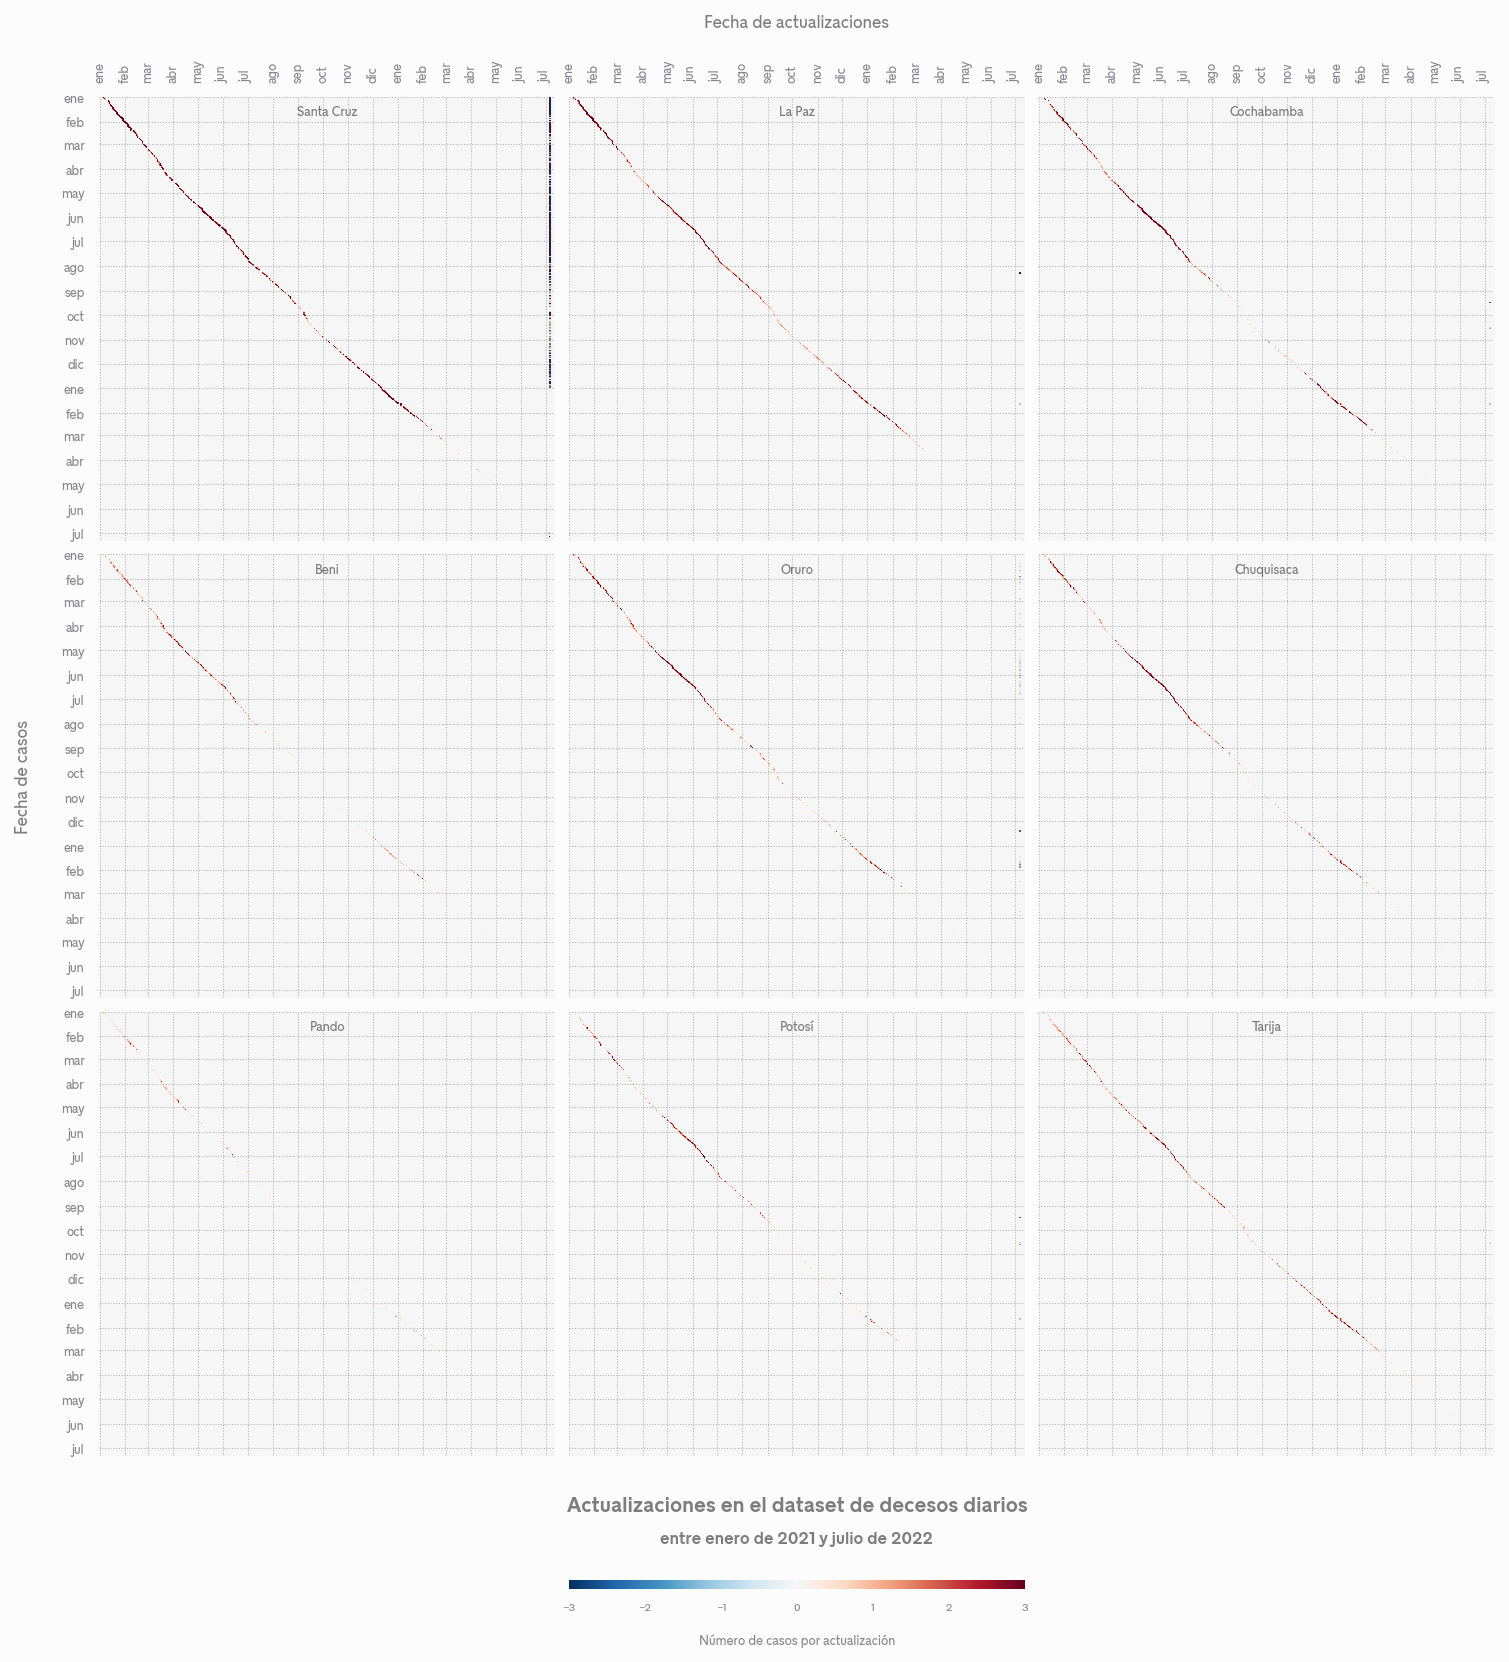

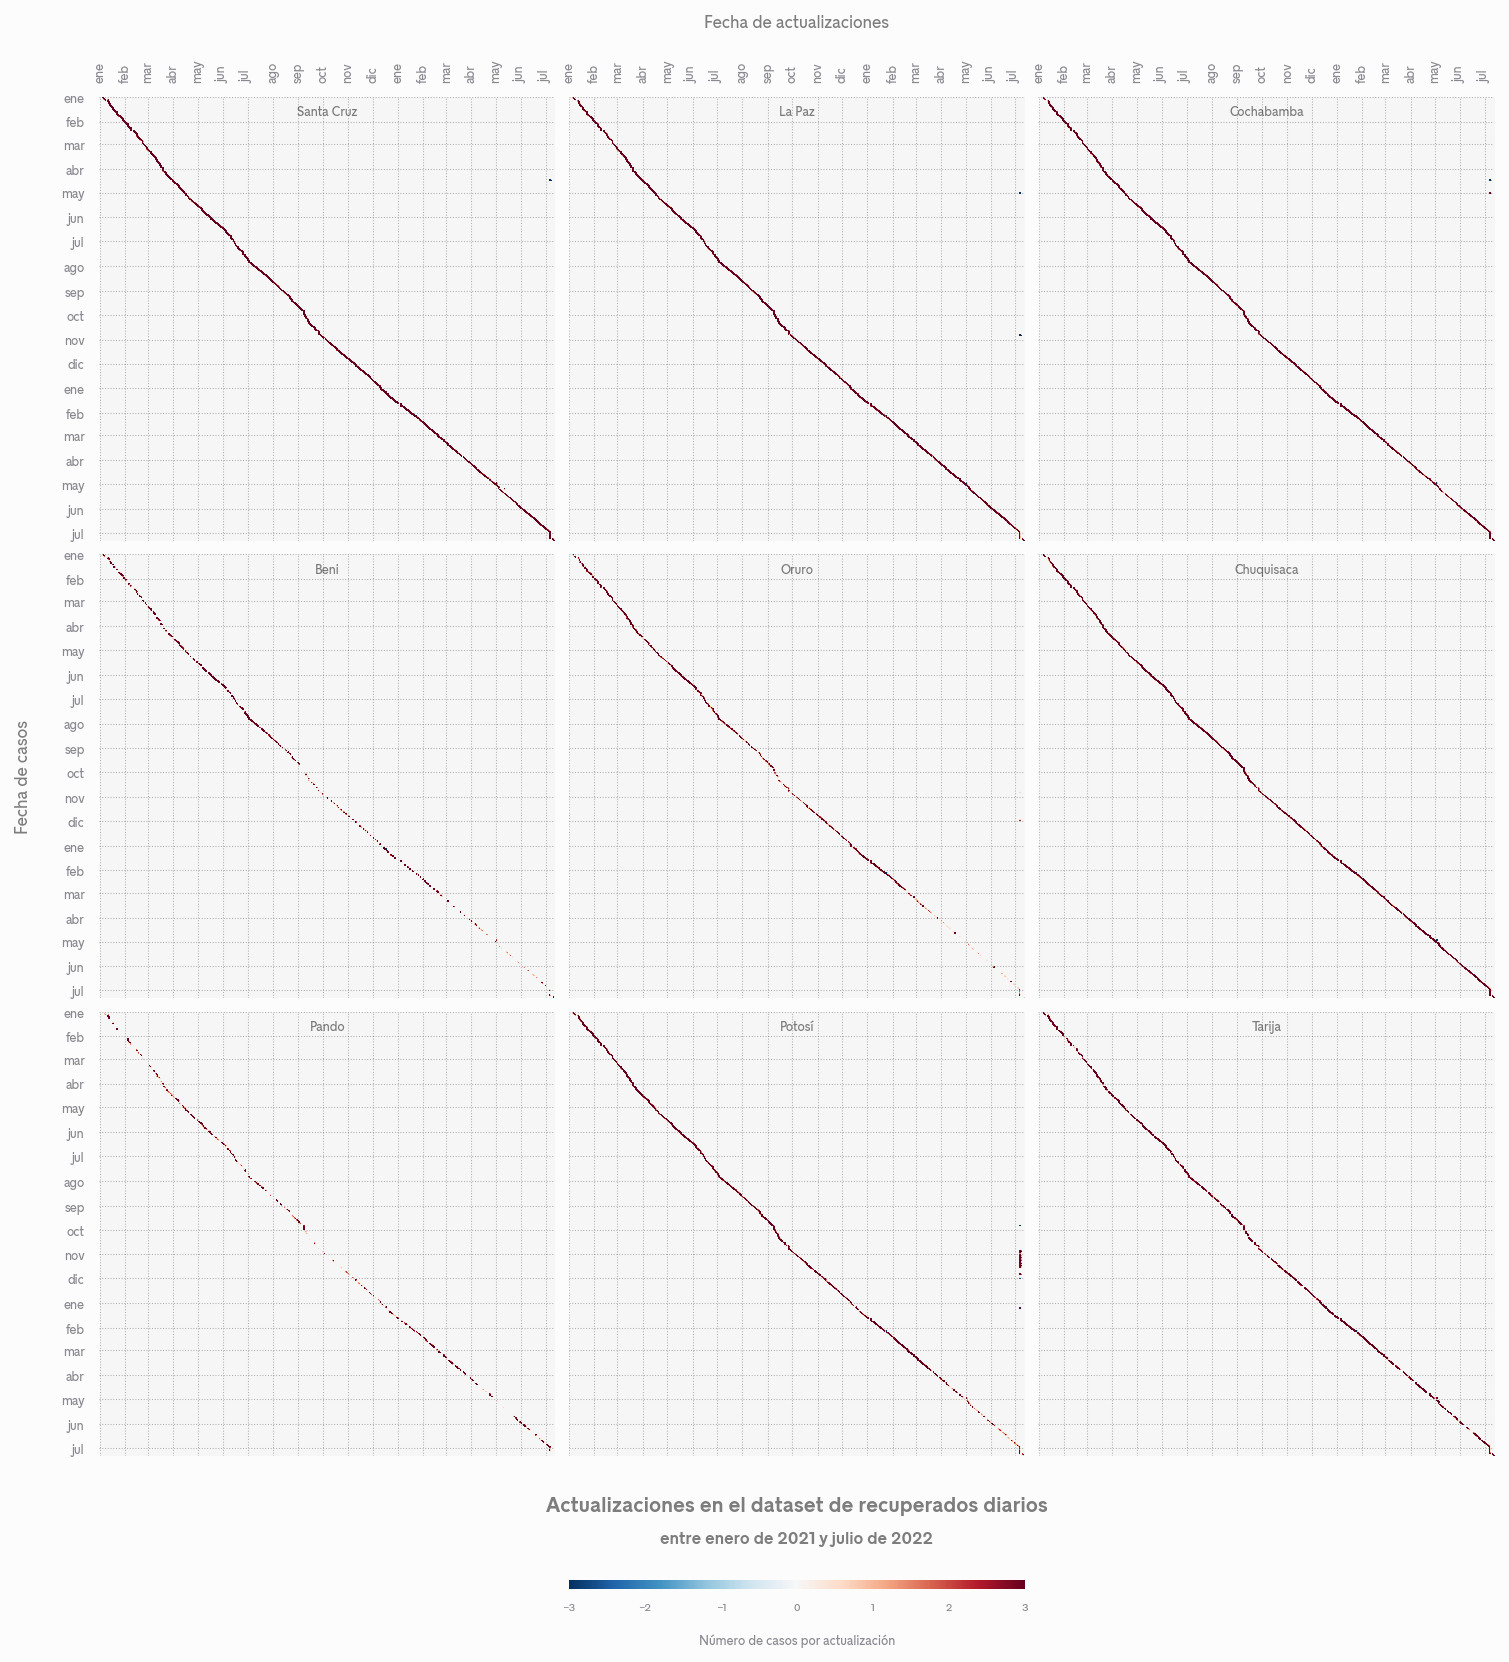

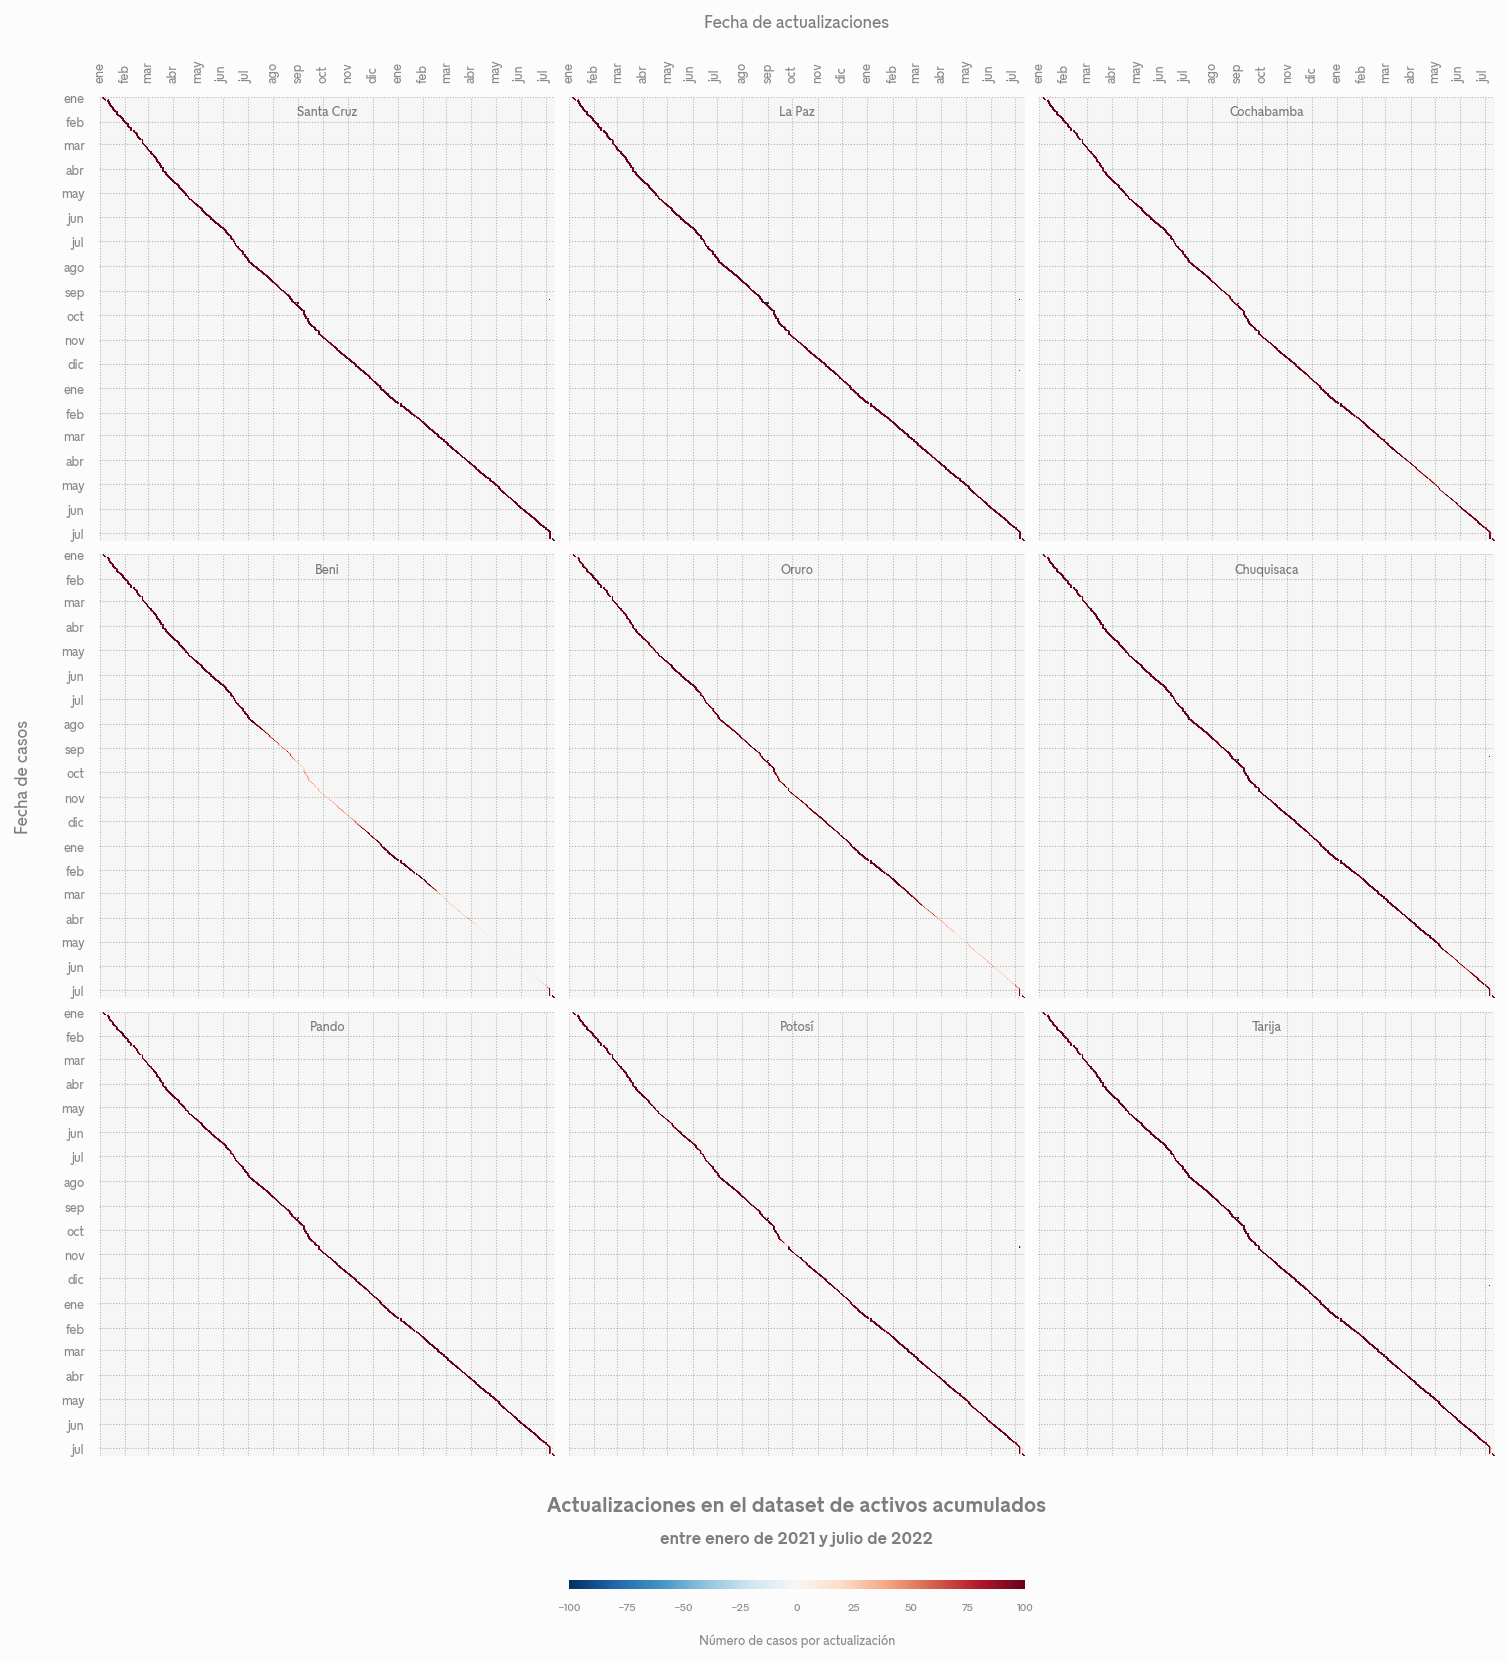

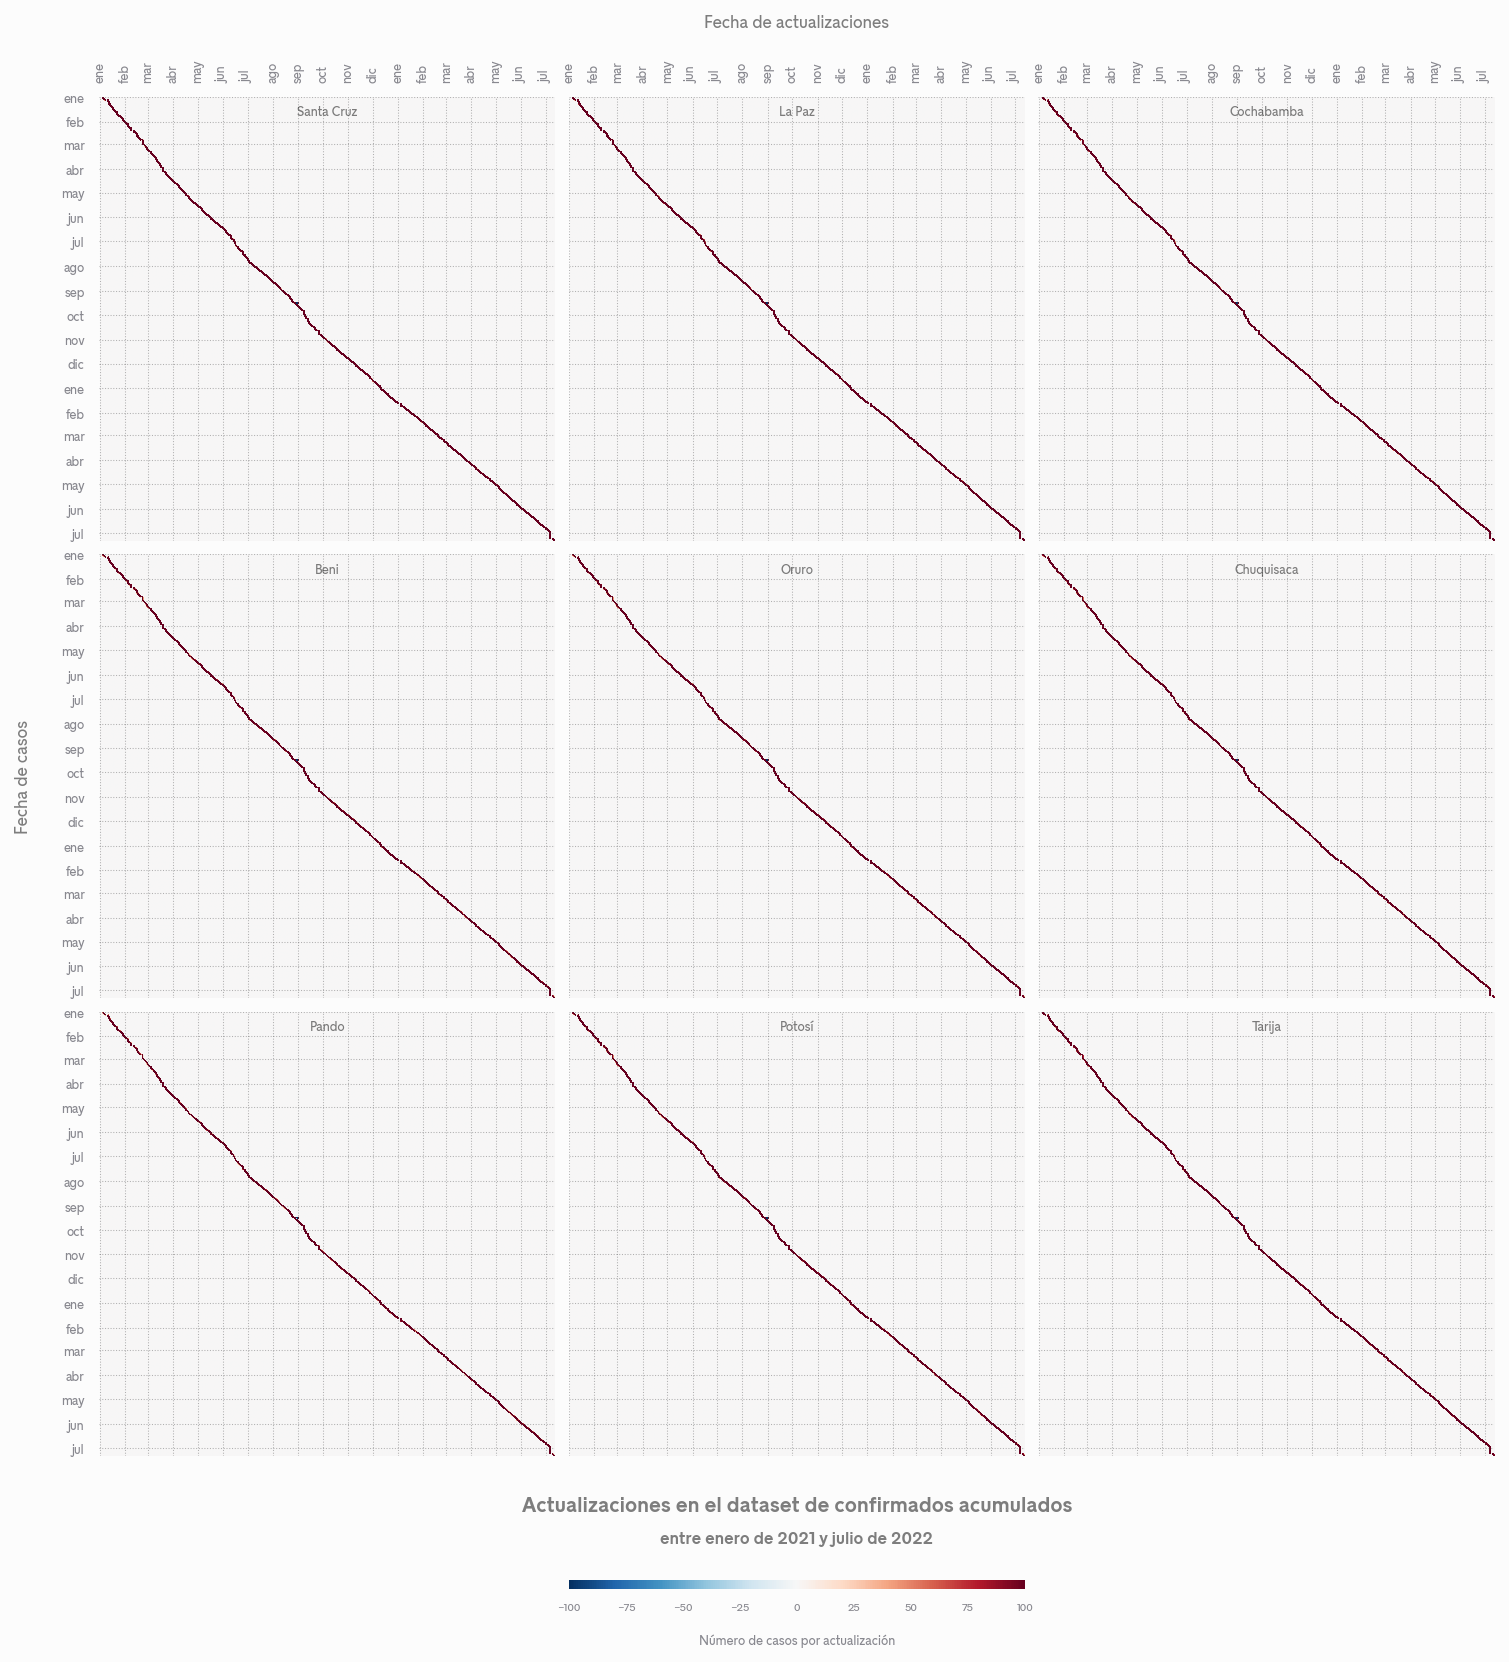

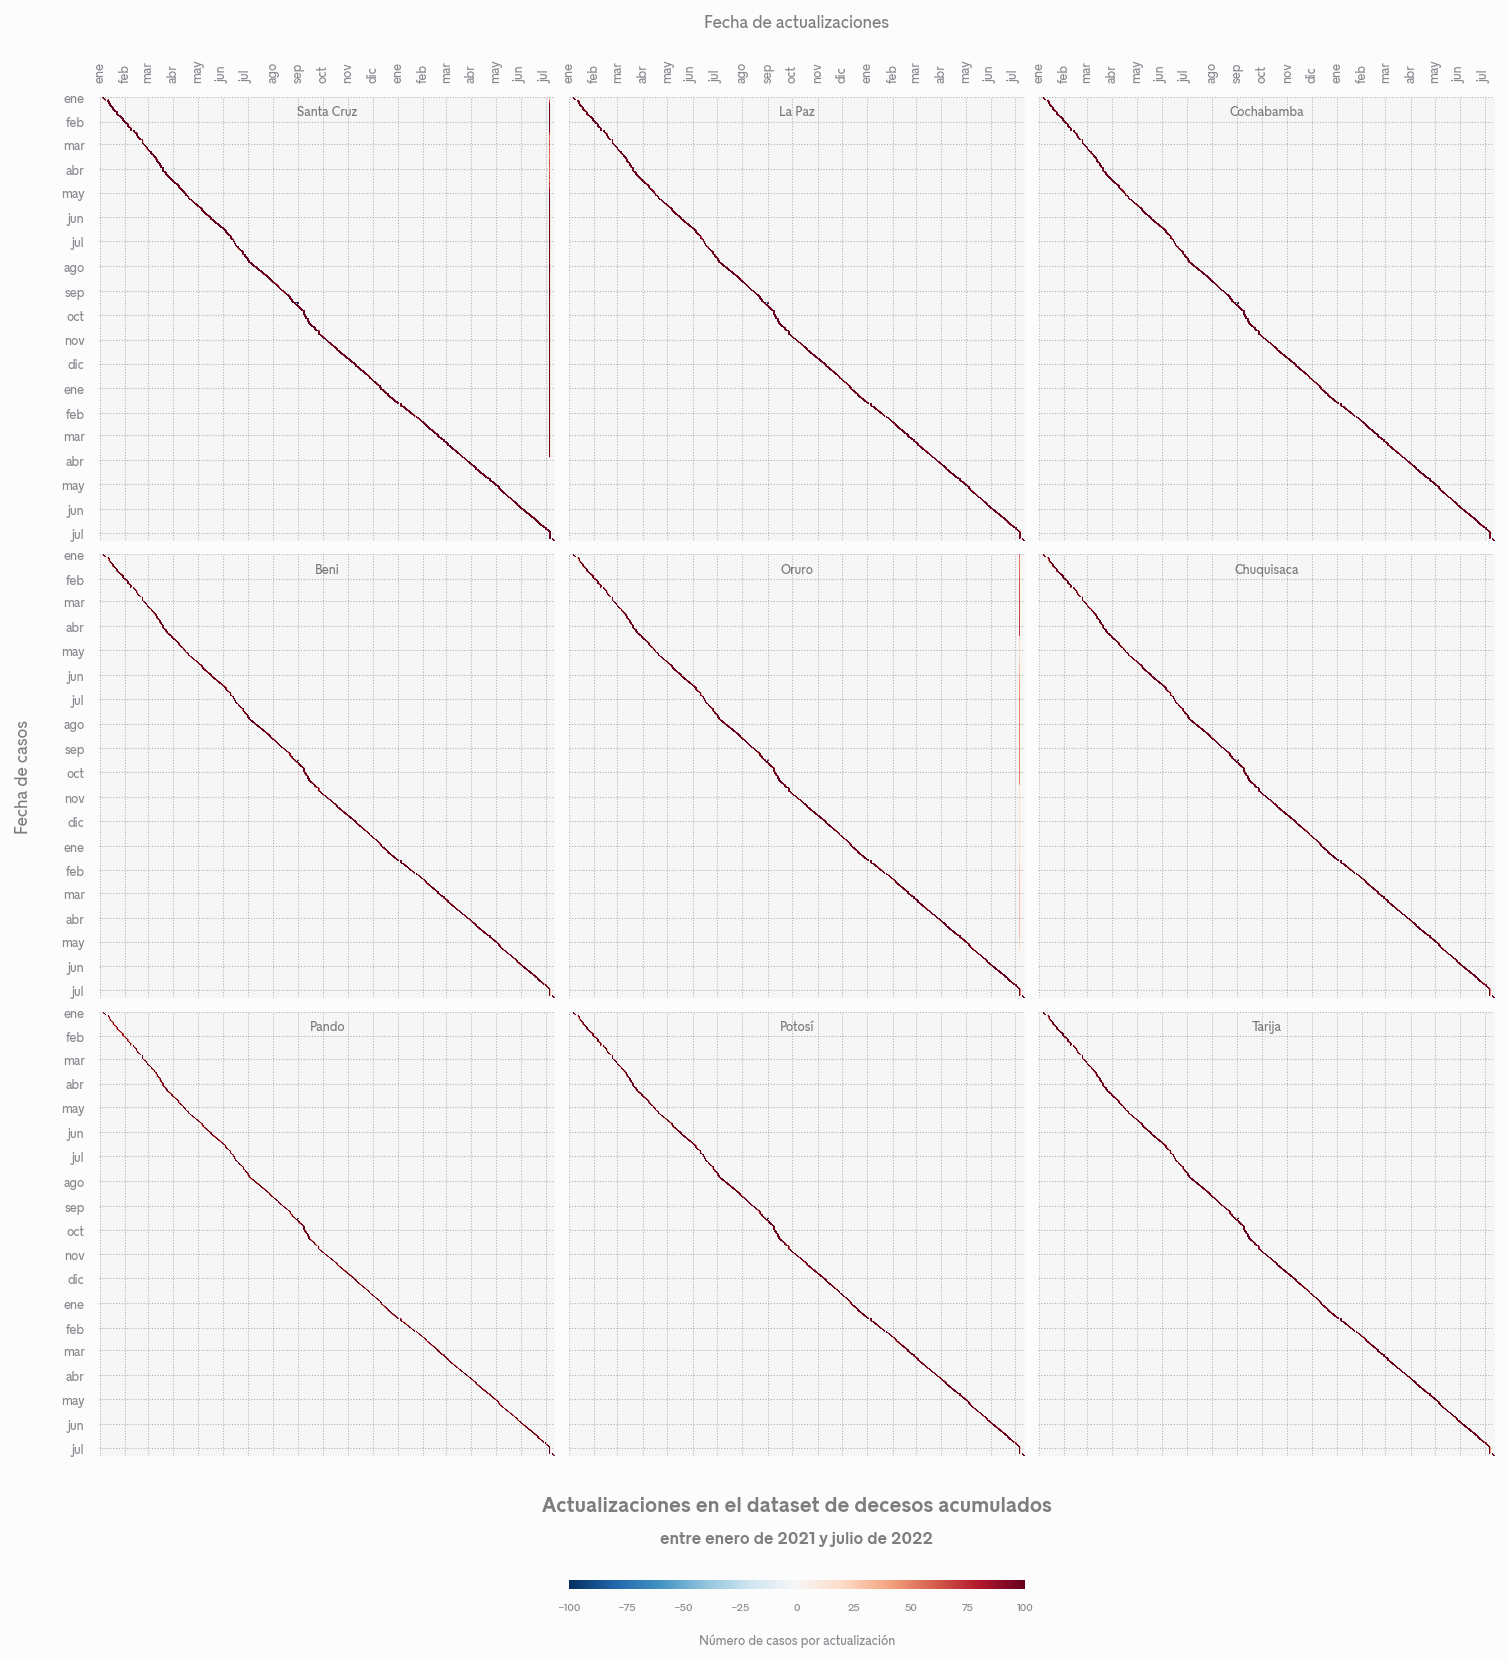

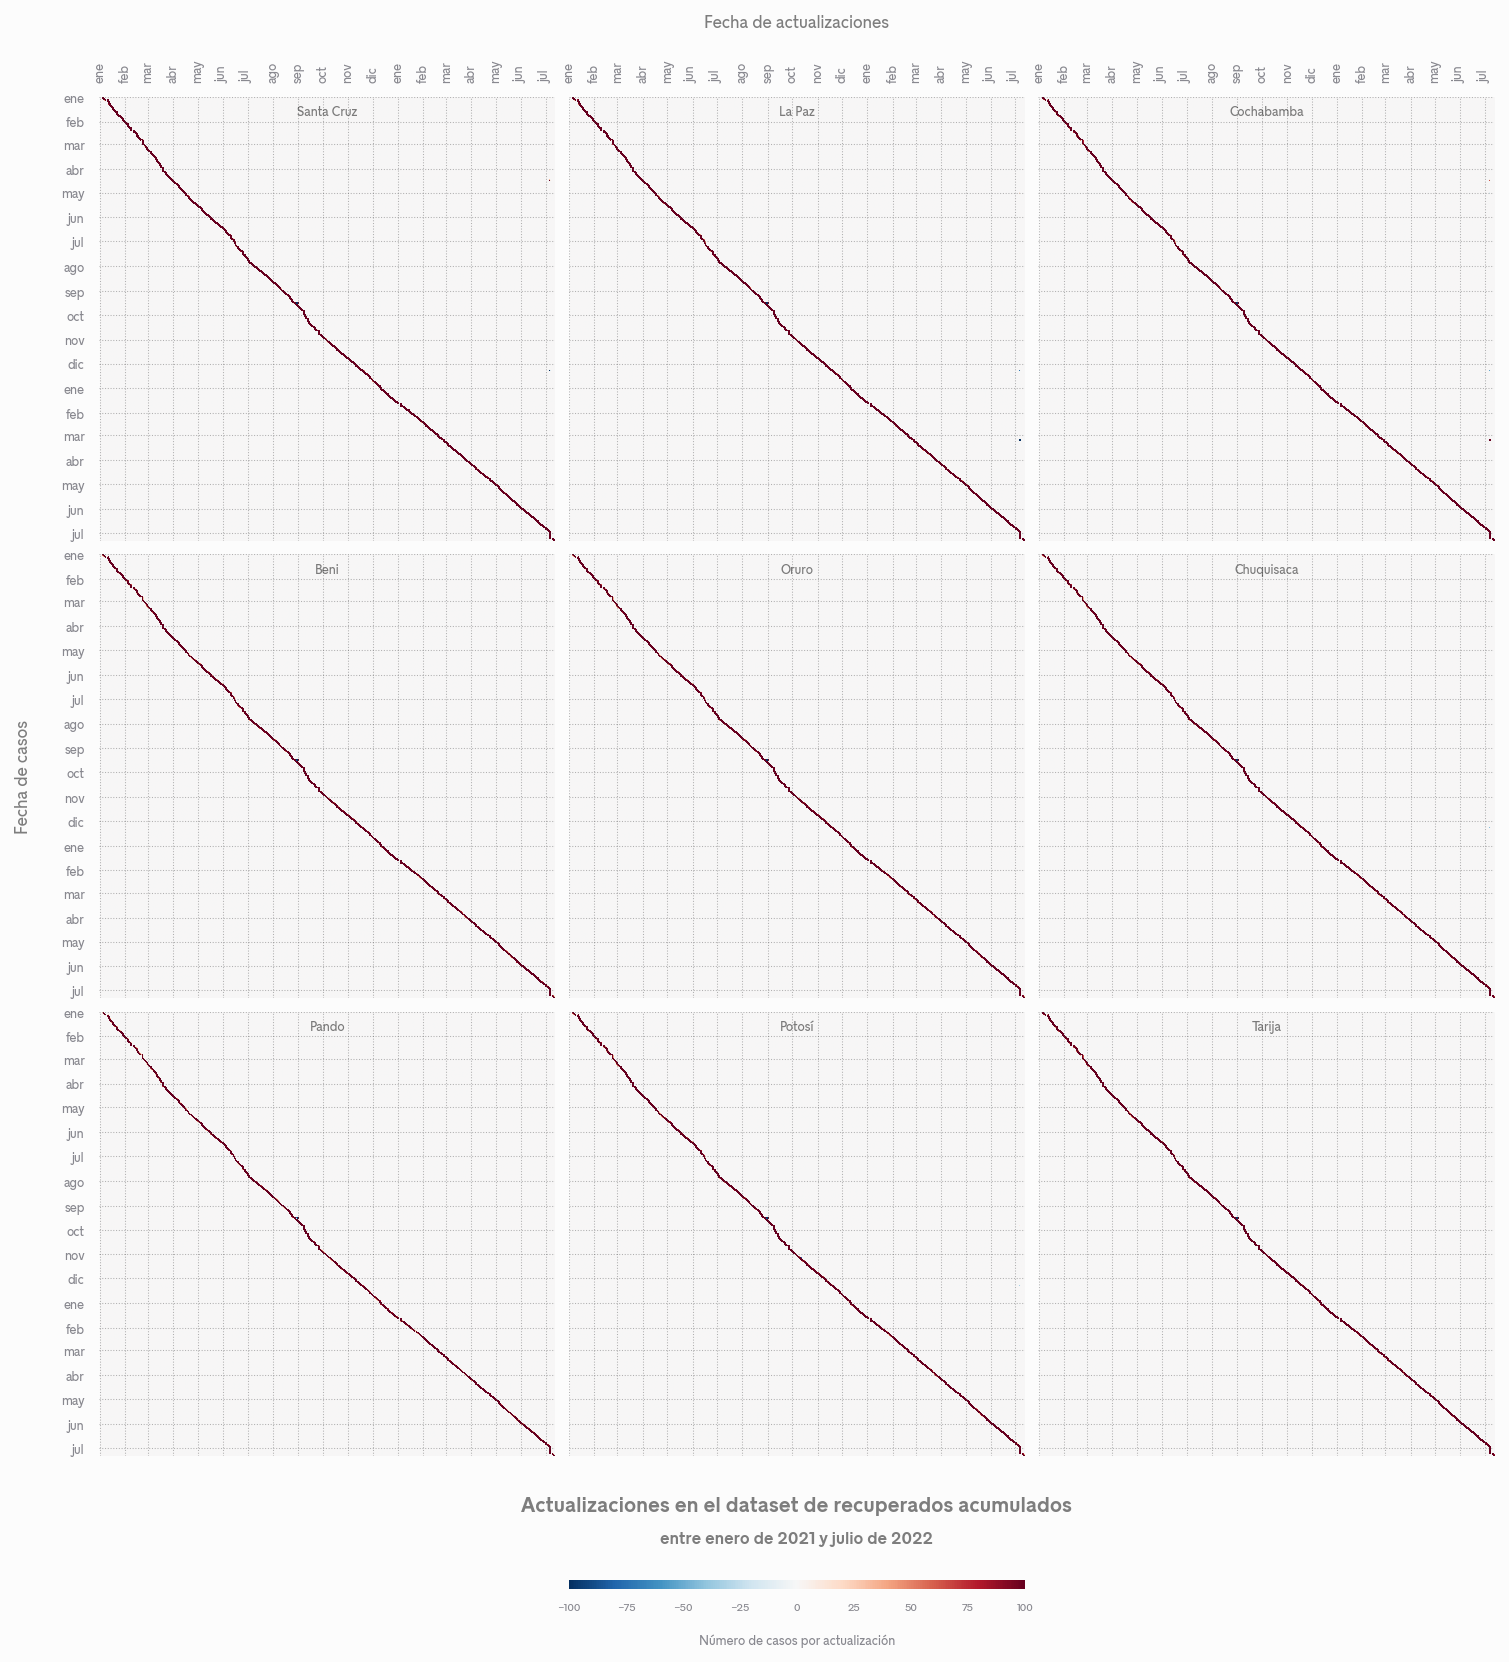

In [385]:
for d in datasets:
    plot_actualizaciones(d)